In [ ]:
## Finished in about 3h20min, including creating a function for image_tracing()
## Managed to do most of the questions
## only 2 dont know (donald projection and project image onto first PC)

In [1]:
import os
import pathlib
import random
import glob
import math
import scipy.io

import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import SimpleITK as sitk

from skimage import color, io, img_as_ubyte, img_as_float, segmentation, measure
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, EuclideanTransform, SimilarityTransform, warp, swirl, matrix_transform 
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening
from skimage.color import label2rgb, rgb2gray
from skimage.filters import median, gaussian, prewitt_h, prewitt_v, prewitt, threshold_otsu

from sklearn import decomposition
from sklearn.decomposition import PCA

from scipy.ndimage import correlate
from scipy.stats import norm
from scipy.spatial import distance

In [2]:
in_dir = "fall2021_data/"

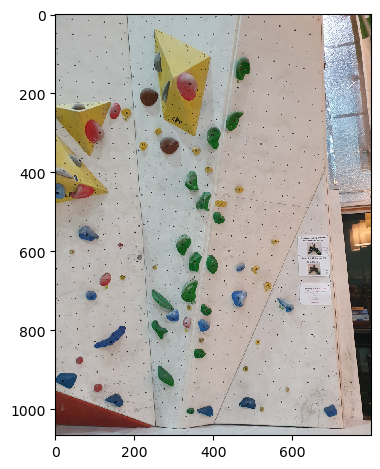

In [3]:
## Climbing Wall
im_name = "ClimbingWall.png"
input_img = io.imread(in_dir + im_name)
io.imshow(input_img)
io.show()

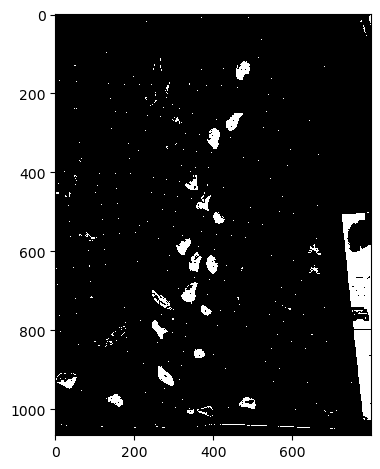

In [4]:
r_comp = input_img[:, :, 0]
g_comp = input_img[:, :, 1]
b_comp = input_img[:, :, 2]

segm = (r_comp < 60) & (g_comp < 200) & (b_comp < 100)
io.imshow(segm)
io.show()

In [5]:
# From https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html
def plot_comparison(original, filtered, filter_name):
    """
    convenience function to show two images side by side:
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

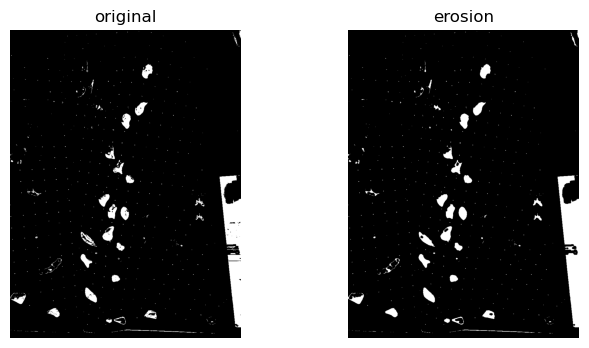

In [6]:
closed = closing(segm, disk(3))
plot_comparison(segm, closed, 'erosion')
# dilated = dilation(closed, disk(3))
# plot_comparison(eroded, dilated, 'dilation')

In [7]:
final_img = segmentation.clear_border(closed)
label_img = measure.label(final_img)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 566


In [8]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
peris = np.array([prop.perimeter for prop in region_props])

count=0
for prop in region_props:
    if prop.area > 300 and prop.perimeter < 500:
        count += 1
count

20

In [9]:
def show_comparison(original, transformed, transformed_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(transformed)
    ax2.set_title(transformed_name)
    ax2.axis('off')
    io.show()

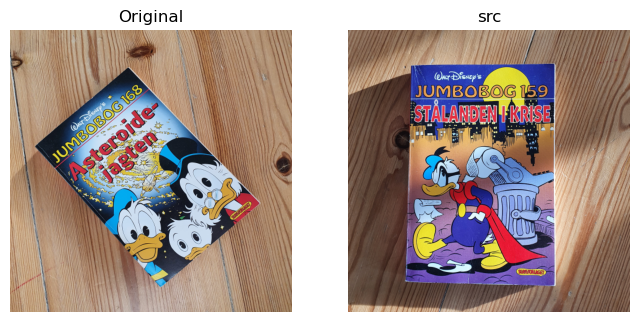

In [10]:
## Donald images
src_img = io.imread(in_dir + 'donald_1.png')
dst_img = io.imread(in_dir + 'donald_2.png')

moving_mat = scipy.io.loadmat(in_dir+'donaldmovingPoints.mat')
fixed_mat = scipy.io.loadmat(in_dir+'donaldfixedPoints.mat')

src = moving_mat["movingPoints"]
dst = fixed_mat["fixedPoints"]
# print(src)
# print(dst)

show_comparison(dst_img, src_img, "src")

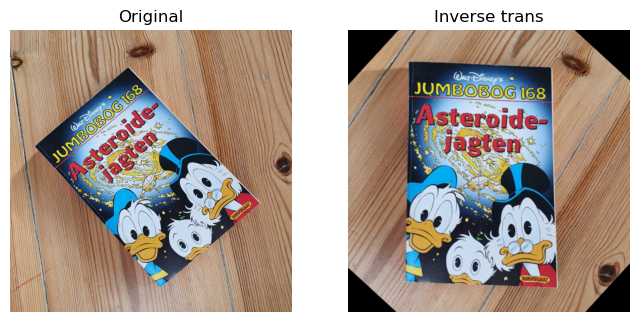

[16 21 31]
[17 21 32]


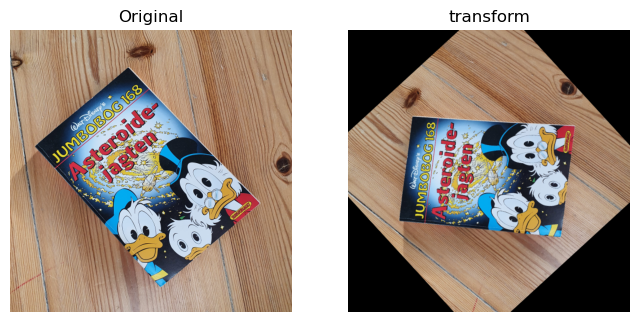

[151 169 186]
[210 227 244]


In [11]:
# Find similarity transform
tform = SimilarityTransform()
tform.estimate(src, dst)

# Apply computed transform to donald_2.png
donald_2 = io.imread(in_dir + 'donald_2.png')
warped = warp(donald_2, tform.inverse)
show_comparison(donald_2, warped, "Inverse trans")

print(img_as_ubyte(warped)[300,300])
print(img_as_ubyte(warped)[299,299])

# ubyte_img = img_as_ubyte(warped)
# for row in range(ubyte_img.shape[0]):
#     for col in range(ubyte_img.shape[1]):
#         if ubyte_img[row,col,0]==145:
#             if ubyte_img[row,col,1]==33:
#                 print(ubyte_img[row,col])
                
#     if pixel[0] == 145:
#     print(pixel)

warped = warp(donald_2, tform)
show_comparison(donald_2, warped, "transform")

print(img_as_ubyte(warped)[300,300])
print(img_as_ubyte(warped)[299,299])

In [12]:
mean_src = src.mean(axis=0)
mean_dst = dst.mean(axis=0)
distance.euclidean(mean_src, mean_dst)

6.411300168277306

In [13]:
5.4e-3/6480*2400 # B: ball height on ccd, in metres

0.002

In [14]:
1.5*0.002/15e-3   # G, in metres

0.2

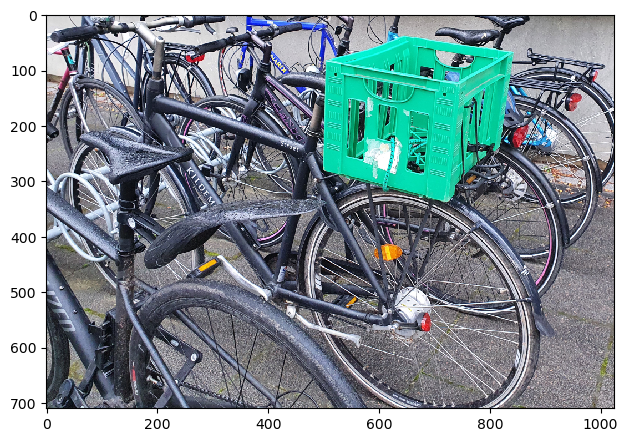

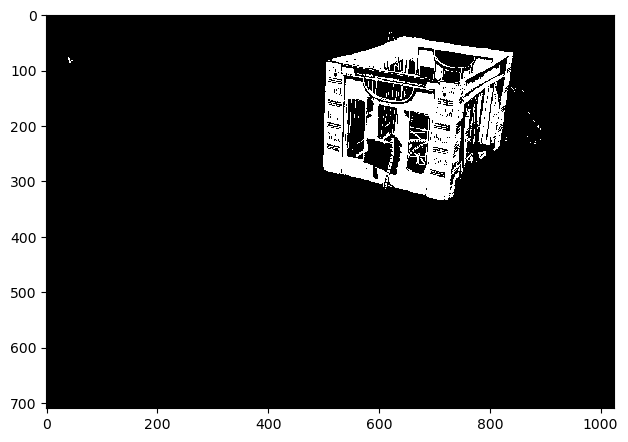

In [15]:
input_img = io.imread(in_dir + "bikes.png")
io.imshow(input_img)
io.show()

r_comp = input_img[:, :, 0]
g_comp = input_img[:, :, 1]
b_comp = input_img[:, :, 2]

segm = (r_comp < 100) & (g_comp > 200) & (b_comp > 100)
io.imshow(segm)
io.show()

In [16]:
closed = closing(segm,disk(8))
ground_truth = io.imread(in_dir+"boxROI.png")
ground_truth = ground_truth > 0

1- distance.dice(closed.ravel(), ground_truth.ravel())

0.9314763598050836

In [17]:
grass = np.array([68,65,67])
road = np.array([70,80,75])
sky = np.array([77,92,89])

grass_mu = np.mean(grass)
road_mu = np.mean(road)
sky_mu = np.mean(sky)

print(grass_mu, road_mu, sky_mu)
print("t1: ", (road_mu+grass_mu)/2)
print("t2: ", (sky_mu+road_mu)/2)

66.66666666666667 75.0 86.0
t1:  70.83333333333334
t2:  80.5


In [18]:
## Parametric classifier
grass_std = np.std(grass)
road_std = np.std(road)
sky_std = np.std(sky)

# find the point when the pdf intercepts
for test_value in range(65,85):
    if norm.pdf(test_value, grass_mu, grass_std) < norm.pdf(test_value, road_mu, road_std):
        print(f"For value {test_value} the class is road")
        break

for test_value in range(70,100):
    if norm.pdf(test_value, sky_mu, sky_std) > norm.pdf(test_value, road_mu, road_std):
        print(f"For value {test_value} the class is sky")
        break


For value 70 the class is road
For value 81 the class is sky


In [19]:
def index(array, item):
    # array is 1-dimensional
    # returns index of first instance of item
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx[0]

def image_tracing(img):
    acc_img = np.zeros(img.shape)
    trace_img = np.zeros(img.shape)

    # initialise first row of accumulator image
    acc_img[0,:] = img[0,:]

    for row in range(1,img.shape[0]):
        for col in range(img.shape[1]):
            # follow 0-indexing
            min_col = max(0,col-1)
            max_col = min(img.shape[1]-1,col+1)
            min_pixel = min(acc_img[row-1,min_col],acc_img[row-1,col],acc_img[row-1,max_col])
            acc_img[row,col] = img[row,col]+min_pixel

            # change to 1-indexing
            idx = index(acc_img[row-1,:],min_pixel)
            idx = idx+1
            trace_img[row,col] = idx
    
    print("input image: \n", img)
    print("accumulator image: \n", acc_img)
    print("trace image: \n", trace_img)
    
    return acc_img, trace_img


In [20]:
img = np.array([[208,71,244,202,173,180],
                [231,139,124,245,193,8],
                [32,244,204,167,189,71],
                [233,246,36,9,100,12],
                [161,40,108,217,167,25],
                [25,248,234,238,44,210]])

acc_img, trace_img = image_tracing(img)
trace_img[4,2]     # row 5, col 3

input image: 
 [[208  71 244 202 173 180]
 [231 139 124 245 193   8]
 [ 32 244 204 167 189  71]
 [233 246  36   9 100  12]
 [161  40 108 217 167  25]
 [ 25 248 234 238  44 210]]
accumulator image: 
 [[208.  71. 244. 202. 173. 180.]
 [302. 210. 195. 418. 366. 181.]
 [242. 439. 399. 362. 370. 252.]
 [475. 488. 398. 371. 352. 264.]
 [636. 438. 479. 569. 431. 289.]
 [463. 686. 672. 669. 333. 499.]]
trace image: 
 [[0. 0. 0. 0. 0. 0.]
 [2. 2. 2. 5. 5. 5.]
 [2. 3. 3. 3. 6. 6.]
 [1. 1. 4. 4. 6. 6.]
 [1. 3. 4. 5. 6. 6.]
 [2. 2. 2. 5. 6. 6.]]


4.0

In [21]:
img = np.array([[64,94,21,19,31],
                [38,88,30,23,92],
                [81,55,47,17,43],
                [53,62,23,23,18],
                [35,59,84,44,90]])

acc_img, trace_img = image_tracing(img)

input image: 
 [[64 94 21 19 31]
 [38 88 30 23 92]
 [81 55 47 17 43]
 [53 62 23 23 18]
 [35 59 84 44 90]]
accumulator image: 
 [[ 64.  94.  21.  19.  31.]
 [102. 109.  49.  42. 111.]
 [183. 104.  89.  59.  85.]
 [157. 151.  82.  82.  77.]
 [186. 141. 166. 121. 167.]]
trace image: 
 [[0. 0. 0. 0. 0.]
 [1. 3. 4. 4. 4.]
 [1. 3. 4. 4. 4.]
 [2. 3. 4. 4. 4.]
 [2. 3. 3. 5. 5.]]


In [22]:
img = np.array([[140,190,73,19,60],
                [130,212,14,100,145],
                [150,20,80,135,120],
                [157,140,33,199,100],
                [121,234,45,210,86]])

acc_img, trace_img = image_tracing(img)
trace_img[4,2]     # row 5, col 3

input image: 
 [[140 190  73  19  60]
 [130 212  14 100 145]
 [150  20  80 135 120]
 [157 140  33 199 100]
 [121 234  45 210  86]]
accumulator image: 
 [[140. 190.  73.  19.  60.]
 [270. 285.  33. 119. 164.]
 [420.  53. 113. 168. 239.]
 [210. 193.  86. 312. 268.]
 [314. 320. 131. 296. 354.]]
trace image: 
 [[0. 0. 0. 0. 0.]
 [1. 3. 4. 4. 4.]
 [1. 3. 3. 3. 4.]
 [2. 2. 2. 3. 4.]
 [2. 3. 3. 3. 5.]]


3.0

In [23]:
## Pizza PCA
txt_name = "pizza.txt"
x = np.loadtxt(in_dir + txt_name, comments="%")

# Check matric dimensions
n_feat = x.shape[1]   # columns
n_obs = x.shape[0]    # rows
print(f"Number of features: {n_feat} and number of observations: {n_obs}")

Number of features: 7 and number of observations: 300


shape:  (300, 7)


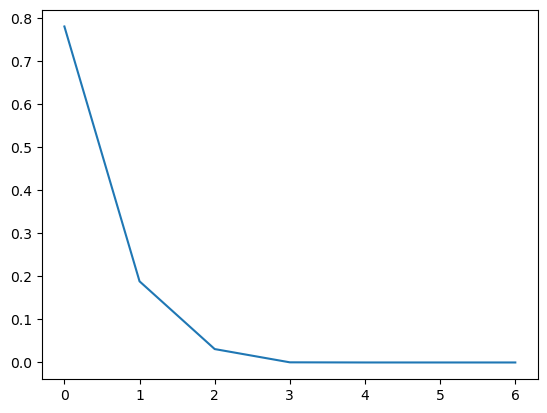

In [24]:
pca = decomposition.PCA()
pca.fit(x)
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_

data_transform = pca.transform(x)
print("shape: ", data_transform.shape)
np.max(data_transform)

plt.plot(pca.explained_variance_ratio_)

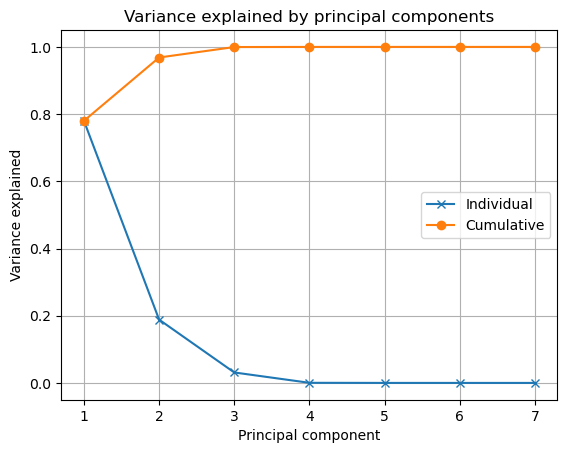

In [25]:
plt.figure()
plt.plot(range(1, len(exp_var_ratio)+1), exp_var_ratio, 'x-')
plt.plot(range(1, len(exp_var_ratio)+1), np.cumsum(exp_var_ratio), 'o-')
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual', 'Cumulative'])
plt.grid()
plt.show()

In [26]:
np.cumsum(exp_var_ratio)

array([0.78010108, 0.96850768, 0.99964088, 0.99998214, 0.99999763,
       0.99999955, 1.        ])

In [27]:
pc1 = vectors_pca[:,0]
mean_nutrient = x.mean(axis=0)   # compute mean of each col
mean_nutrient - pc1*3

array([41.73395695, 15.61478771, 21.28558187,  2.04553393,  0.84782423,
       21.54184498,  3.0613253 ])

In [28]:
x[:,0].mean()

40.90306666666667

In [29]:
vectors_pca

array([[-2.76963426e-01, -2.66941457e-01, -2.78933559e-01,
        -5.54340960e-02, -1.11416057e-02,  8.78084364e-01,
        -6.03287596e-04],
       [-7.47073681e-01,  5.57329479e-02,  6.57845306e-01,
         4.06042105e-02,  2.38137604e-02, -6.81755096e-03,
         6.12538275e-02],
       [-3.52016178e-01,  8.09717965e-01, -4.67976440e-01,
         2.22252811e-02, -2.62446886e-02, -1.24692885e-02,
        -1.00622712e-02],
       [ 1.95899801e-01,  2.55747087e-01,  2.59802148e-01,
        -8.71443239e-01, -2.01452647e-01,  1.64524607e-01,
         4.06780739e-02],
       [-5.94747417e-02, -8.37192422e-02, -3.57756435e-02,
         1.66633512e-01, -9.78316010e-01, -5.74696813e-02,
        -1.49699419e-03],
       [ 4.40973897e-01,  4.43489799e-01,  4.48624300e-01,
         4.50220250e-01, -3.04634491e-02,  4.44405399e-01,
        -8.04524971e-02],
       [ 6.98915671e-02,  2.99036492e-02, -1.98207032e-02,
         7.00433927e-02,  2.56524121e-03,  2.99769686e-02,
         9.9399034

In [30]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

In [31]:
# compute data matrix
all_images = ['orchid001.png','orchid002.png','orchid003.png',\
              'orchid004.png','orchid005.png','orchid006.png']
all_images = [in_dir+'orchid/'+filename for filename in all_images]
n_samples = len(all_images)
n_samples

6

In [32]:
# read first image
first_img = io.imread(all_images[0])
height, width = first_img.shape
channels=1
n_features = height*width*channels

print("n_samples: ", n_samples)
print("n_features: ", n_features)

n_samples:  6
n_features:  213200


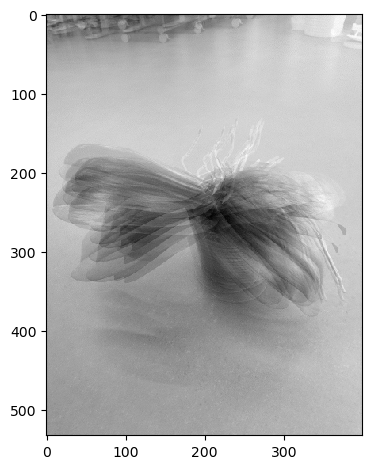

In [33]:
data_matrix = np.zeros((n_samples, n_features))
for idx,img_path in enumerate(all_images):
    img = io.imread(img_path)
    data_matrix[idx,:] = img.flatten()
    
# compute average
avg_orchid = np.mean(data_matrix,axis=0)
avg_orchid_img = create_u_byte_image_from_vector(avg_orchid, height, width, channels)
io.imshow(avg_orchid_img)
io.show()

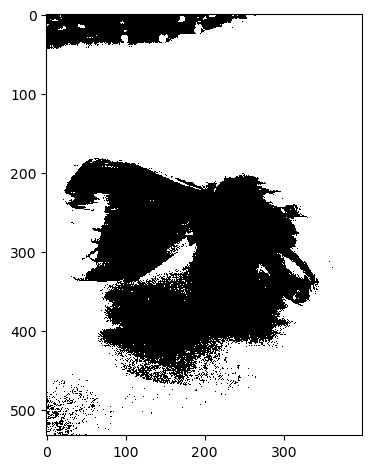

In [34]:
thres_img = avg_orchid_img > 150
io.imshow(thres_img)
io.show()

In [35]:
# compute data matrix
all_images = ['orchid001.png','orchid002.png','orchid003.png',\
              'orchid004.png','orchid005.png','orchid006.png','orchid007.png']
all_images = [in_dir+'orchid/'+filename for filename in all_images]
n_samples = len(all_images)
n_samples

7

In [36]:
# PCA on 6 orchid images

pca = decomposition.PCA()
pca.fit(data_matrix)      # data_matrix is (6, 213200)
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_       # vectors_pca is (6, 213200)
# plt.plot(pca.explained_variance_ratio_)

In [38]:
new_flower = io.imread(in_dir+'orchid/orchid007.png')
temp = new_flower.flatten().reshape((-1,1)).T - data_matrix.mean(axis=0)
projection = temp@vectors_pca.T
projection[0][0]

-6310.705390756462

In [39]:
new_flower.flatten().reshape((-1,1)).T.shape

(1, 213200)

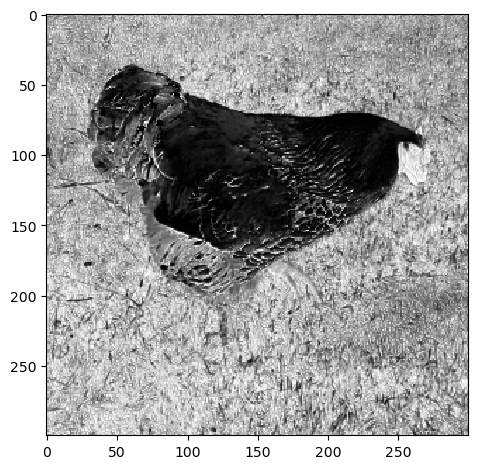

In [40]:
input_img = io.imread(in_dir + "bird.png")
hsv_img = color.rgb2hsv(input_img)
sat_img = hsv_img[:,:,1]
io.imshow(sat_img)
io.show()

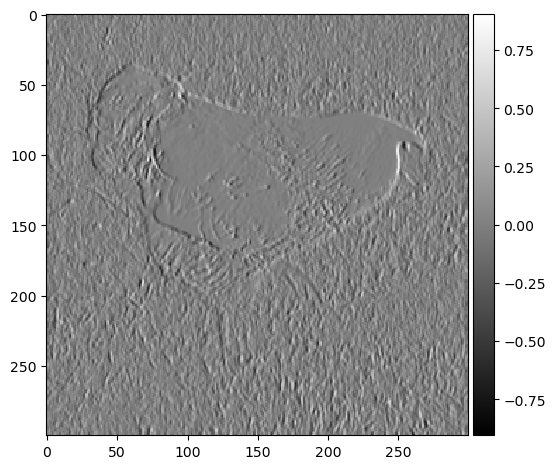

In [41]:
edges_v = prewitt_v(sat_img)
io.imshow(edges_v, cmap='gray')
io.show()

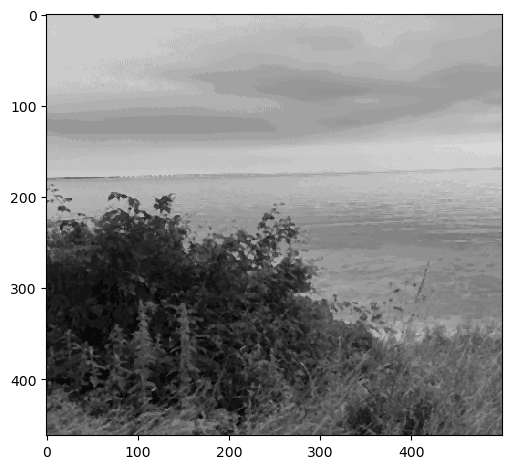

In [42]:
input_img = io.imread(in_dir + "water_gray.png")

size = 3
footprint = np.ones([size, size])
med_img = median(input_img, footprint)

io.imshow(med_img)
io.show()

216

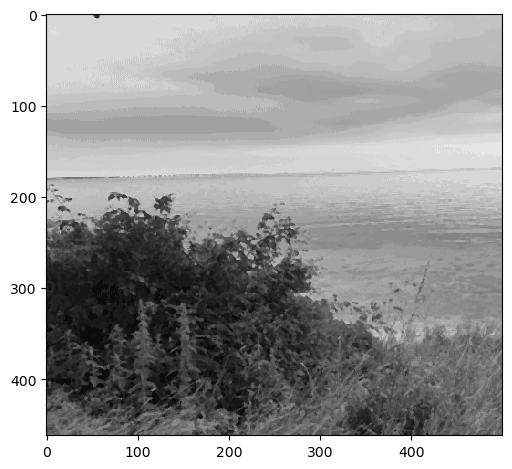

In [43]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched according to 
             min_desired and max_desired
    """
    # img_as_float will divide all pixel values with 255.0
#     img_float = img_as_float(img_in)
    min_val = img_in.min()
    max_val = img_in.max()
    min_desired = 12
    max_desired = 230

    # Do something here
    img_out = img_in
    for i in range(img_in.shape[0]):
        for j in range(img_in.shape[1]):
            new = (img_in[i,j] - min_val)*(max_desired - min_desired)/(max_val - min_val) + min_desired
            img_out[i,j] = new
    
    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)

im_stretched = histogram_stretch(med_img)
io.imshow(im_stretched)
im_stretched[20,20]


In [44]:
ct = dicom.read_file(in_dir + '1-131.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


In [45]:
# Exercise 4: plot for other organsO
ROI = ['LiverROI', 'SpleenROI', 'BoneROI']
mu_organs = []
std_organs = []
for roi in ROI:
    roi_img = io.imread(in_dir + roi + '.png')
    organ_mask = roi_img > 0
    organ_values = img[organ_mask]
    mu_organ = np.mean(organ_values)
    std_organ = np.std(organ_values)
    mu_organs.append(mu_organ)
    std_organs.append(std_organ)
#     n, bins, patches = plt.hist(organ_values, 60, density=1)
#     pdf_spleen = norm.pdf(bins, mu_organ, std_organ)
#     plt.plot(bins, pdf_spleen)
#     plt.xlabel('Hounsfield unit')
#     plt.ylabel('Frequency')
#     plt.title(roi + ' values in CT scan')
#     plt.show()

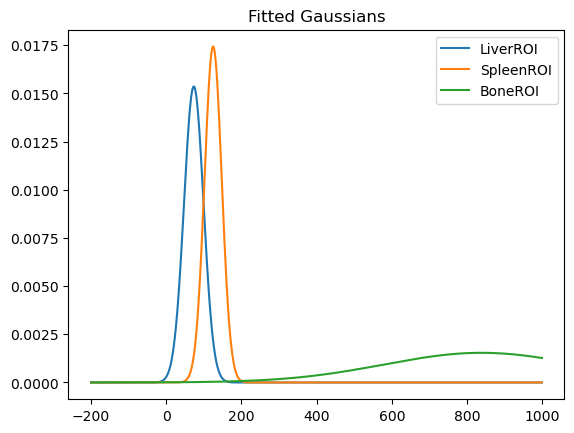

In [46]:
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
for i in range(len(ROI)):
    pdf_organ = norm.pdf(hu_range,mu_organs[i],std_organs[i])
    plt.plot(hu_range,pdf_organ,label=ROI[i])
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

In [47]:
mu_organs

[73.28221208665906, 124.72452830188679, 838.4418604651163]

In [48]:
t1 = (mu_organs[0]+mu_organs[1])/2
t2 = (mu_organs[2]+mu_organs[1])/2
print(t1,t2)

99.00337019427292 481.58319438350156


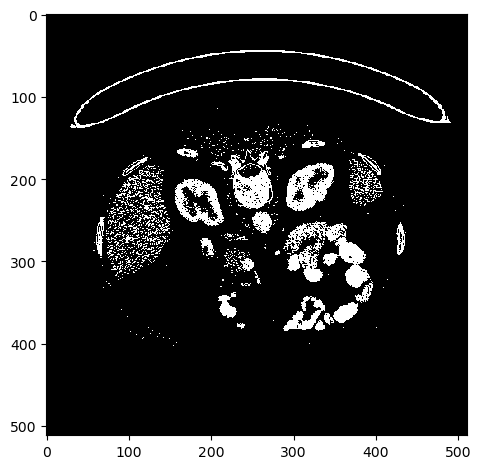

In [49]:
T1 = 85
T2 = 400
thresholded = (img>T1) & (img<T2)
io.imshow(thresholded)
io.show()

In [50]:
closed = closing(thresholded, disk(5))
opened = opening(closed, disk(3))

label_img = measure.label(opened)
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])

areas = [area for area in areas if (area>1000) and (area<4000)]
print(len(areas))

3
